##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorBoard DataFrame API

## Overview

The main feature of TensorBoard is its interactive GUI. However, users sometimes want to **programmatically** read the data logs stored in TensorBoard, for purposes such as performing post-hoc analyses and creating custom visualizations of the log data.

A feature is introduced in TensorBoard v2.3 supports this use case:  `tensorboard.data.experimental.ExperimentFromDev()`. It allows programmatic access to TensorBoard's scalar logs. This page demonstrates the basic usage of this new API.

**Note:**
1. This API is still in its experimental stage, as reflected by its API namespace. This means the API may be subject to breaking changes in the future.
2. Currently, this feature supports only logdirs uploaded to TensorBoard.dev, a free hosted service for persisting and sharing your TensorBoard. Support for locally stored TensorBoard logdir will be added in the future. Briefly, you can upload a TensorBoard logdir on you local filesystem to tensorboard.dev with a single line of command: `tensorboard dev upload --logdir <logdir>`. See the documentation at [tensorboard.dev](https://tensorboard.dev) for more details.

## Setup

`pandas` must be installed alongside `tensorboard` to make the API usable.
If you intend to make custom plots by using the data output by the new API, `matplotlib` and `seaborn` should be installed as well.

In [ ]:
!pip install tensorboard pandas
!pip install matplotlib seaborn

In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [2]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.3.0a20200615


## Loading TensorBoard scalars as a `pandas.DataFrame`

Once a TensorBoard logdir has been uploaded to TensorBoard.dev, it becomes what we refer to as an *experiment*. Each experiment has a unique ID, which can be found in the TensorBoard.dev URL of the experiemnt. For our demonstration below, we will use a TensorBoard.dev experiment at:
https://tensorboard.dev/experiment/c1KCv3X3QvGwaXfgX1c4tg

In [3]:
# Specify the ID of the experiment, which can be obtained from the
# TensorBoard.dev URL.
experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,"adam,run_1/train",epoch_accuracy,0,0.966867
1,"adam,run_1/train",epoch_accuracy,1,0.986283
2,"adam,run_1/train",epoch_accuracy,2,0.989333
3,"adam,run_1/train",epoch_accuracy,3,0.991933
4,"adam,run_1/train",epoch_accuracy,4,0.991733
...,...,...,...,...
1195,"sgd,run_5/validation",epoch_loss,15,0.020157
1196,"sgd,run_5/validation",epoch_loss,16,0.020212
1197,"sgd,run_5/validation",epoch_loss,17,0.020364
1198,"sgd,run_5/validation",epoch_loss,18,0.022192


`df` is a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) that contains all scalar logs of the experiment.

The columns of the `DataFrame` are:
- `run`: each run corresponds to subdirectories of the original logdir. In this experiment, each run is from  a complete training of a convolutional neural network (CNN) on the MNIST dataset with a given optimizer type  (a training hyperparameter). This `DataFrame` contains multiple such runs, which correspond to repeated training runs under different optimizer types.
- `tag`: this describes what the `value` in the same row means. In this experiment, we have only two unique tags: `epoch_accuracy` and `epoch_loss` for the accuracy and loss metrics respectively.
- `step`: This is a number that reflects the serial order of the corresponding row in its run. Here `step` actually refers to epoch number. If you wish to obtain the timestamps in addition to the `step` values, you can use the keyword argument `include_wall_time=True` when calling `get_scalars()`.
- `value`: This is the actual numerical value of interest. As described above, each `value` in this particular `DataFrame` is either a loss or an accuracy, depending on the `tag` of the row.

In [4]:
print(df["run"].unique())
print(df["tag"].unique())

['adam,run_1/train' 'adam,run_1/validation' 'adam,run_2/train'
 'adam,run_2/validation' 'adam,run_3/train' 'adam,run_3/validation'
 'adam,run_4/train' 'adam,run_4/validation' 'adam,run_5/train'
 'adam,run_5/validation' 'rmsprop,run_1/train' 'rmsprop,run_1/validation'
 'rmsprop,run_2/train' 'rmsprop,run_2/validation' 'rmsprop,run_3/train'
 'rmsprop,run_3/validation' 'rmsprop,run_4/train'
 'rmsprop,run_4/validation' 'rmsprop,run_5/train'
 'rmsprop,run_5/validation' 'sgd,run_1/train' 'sgd,run_1/validation'
 'sgd,run_2/train' 'sgd,run_2/validation' 'sgd,run_3/train'
 'sgd,run_3/validation' 'sgd,run_4/train' 'sgd,run_4/validation'
 'sgd,run_5/train' 'sgd,run_5/validation']
['epoch_accuracy' 'epoch_loss']


## Getting a Pivoted (Wide-Form) DataFrame

In our experiment, the two tags (`epoch_loss` and `epoch_accuracy`) are present at the same set of steps in each run. This makes it possible to obtain a "wide-form" `DataFrame` directly from `get_scalars()` by using the `pivot=True` keyword argument. The wide-form `DataFrame` has all its tags included as columns of the DataFrame, which is more convenient to work with in some cases including this one.

However, beware that if the the condition of having uniform sets of step values across all tags in all runs is not met, using `pivot=True` will result in an error.

In [5]:
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,epoch_accuracy,epoch_loss
0,"adam,run_1/train",0,0.966867,0.110196
1,"adam,run_1/train",1,0.986283,0.042437
2,"adam,run_1/train",2,0.989333,0.032622
3,"adam,run_1/train",3,0.991933,0.026121
4,"adam,run_1/train",4,0.991733,0.024742
...,...,...,...,...
595,"sgd,run_5/validation",15,0.993800,0.020157
596,"sgd,run_5/validation",16,0.993500,0.020212
597,"sgd,run_5/validation",17,0.993800,0.020364
598,"sgd,run_5/validation",18,0.993100,0.022192


Notice that instead of a single "value" column, the wide-form DataFrame includes the two tags (metrics) as its columns explicitly: `epoch_accuracy` and `epoch_loss`.

## Saving the DataFrame as CSV

`pandas.DataFrame` has good interoperability with [CSV](https://en.wikipedia.org/wiki/Comma-separated_values). You can store it as a local CSV file and load it back later. For example:

In [6]:
csv_path = '/tmp/tb_experiment_1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

## Performing custom visualization and statistical analysis

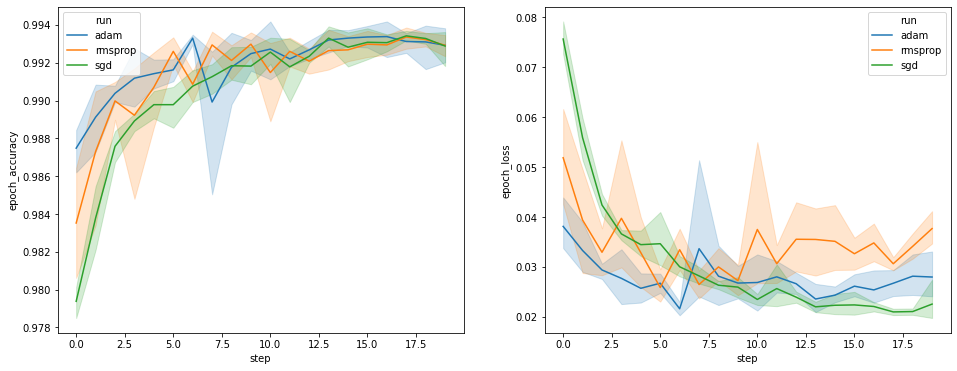

In [7]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
             hue=optimizer_validation)
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation)

The plots above show the timecourses of validation accuracy and validation loss. Each curve shows the average across 5 runs under an optimizer type. Thanks to a built-in feature of `seaborn.lineplot()`, each curve also displays ±1 standard deviation around the mean, which gives us a clear sense of the variability in these curves and the significance of the differences among the three optimizer types. This visualization of variability is not supported by TensorBoard's main GUI currently.

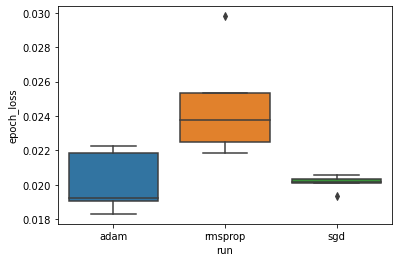

In [8]:
# We want to study the hypothesis that the minimum validation loss
# differs significantly beteen the "adam", "rmsprop" and "sgd" optimizers.
# So we extract a DataFrame for the minimum validation loss under each
# of the optimizers.
adam_min_val_loss = dfw_validation.loc[optimizer_validation=="adam", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
rmsprop_min_val_loss = dfw_validation.loc[optimizer_validation=="rmsprop", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
sgd_min_val_loss = dfw_validation.loc[optimizer_validation=="sgd", :].groupby(
    "run", as_index=False).agg({"epoch_loss": "min"})
min_val_loss = pd.concat([adam_min_val_loss, rmsprop_min_val_loss, sgd_min_val_loss])

# Make a boxplot to visualize the difference in the minimum validation losses.
sns.boxplot(data=min_val_loss, y="epoch_loss",
            x=min_val_loss.run.apply(lambda run: run.split(",")[0]))

In [9]:
# Perform pairwise comparisons between the minimum validation losses
# from the three optimizers.
_, p_adam_vs_rmsprop = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    rmsprop_min_val_loss["epoch_loss"]) 
_, p_adam_vs_sgd = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
_, p_rmsprop_vs_sgd = stats.ttest_ind(
    rmsprop_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"]) 
print("adam vs. rmsprop: p = %.4f" % p_adam_vs_rmsprop)
print("adam vs. sgd: p = %.4f" % p_adam_vs_sgd)
print("rmsprop vs. sgd: p = %.4f" % p_rmsprop_vs_sgd)

adam vs. rmsprop: p = 0.0244
adam vs. sgd: p = 0.9749
rmsprop vs. sgd: p = 0.0135


Therefore, at a significance level of 0.05, our analysis confirms our hypothesis that the minimum validation loss is significantly higher (i.e., worse) in the rmsprop optimizer compared to the other two optimizers included in our experiment. 

In summary, this tutorial provides an example of how to access scalar data as `panda.DataFrame`s from TensorBoard.dev. It demonstrates the kind of flexible and powerful analyses and visualization you can do with the `DataFrame`s.